In [1]:
# ANOTHER VIEW OF ML CLASSIFIERS 
# USING MNIST AS EXAMPLE DATA
# BASED ON GERON (2017)

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
from sklearn.base import BaseEstimator
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier


In [2]:
# OBTAIN

from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')
mnist


{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([ 0.,  0.,  0., ...,  9.,  9.,  9.])}

In [3]:
# OBTAIN
# CHECK ON IMAGE SIZE / SHAPE
# REMEMBER - VECTOR SIZE IS 28 * 28 - 784

X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

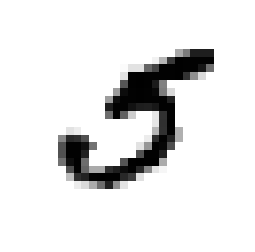

In [4]:
# EXPLORE

some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary,
           interpolation="nearest")
plt.axis("off")

plt.show()

In [5]:
# EXPLORE 
# CREATE FUNCTION FOR PLOTTING DIGIT
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = matplotlib.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [6]:
# EXPLORE
# CREATE FUNCTION FOR PLOTTING MULTIPLE DIGITS

def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

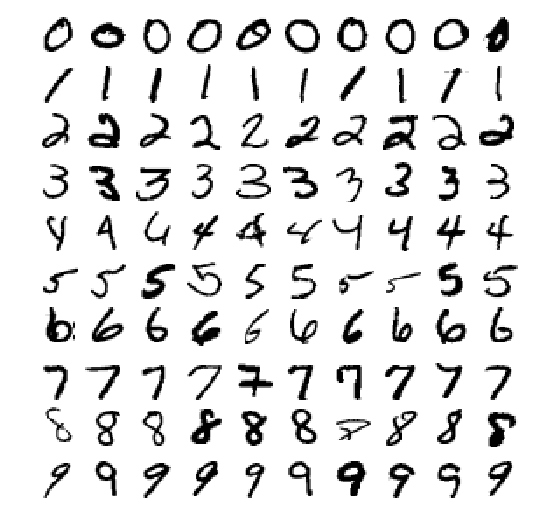

In [7]:
# EXPLORE
# LOOK AT MULTIPLE IMAGES
plt.figure(figsize=(9,9))
example_images = np.r_[X[:12000:600], X[13000:30600:600], X[30600:60000:590]]
plot_digits(example_images, images_per_row=10)

plt.show()

In [8]:
# SCRUB
# SPLIT INTO TEST AND TRAINING

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# SHUFFLE TRAINING SEQUENCE
# USING RANDOM SEQUENCE FROM NUMPY

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

## Yes / No Classifier

Simple classifier to determine if digit is (or is not) a 5.

In [9]:
# MODEL
# SET UP TRAINING CASES / TEST CASES

y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [10]:
# MODEL
# USING STOCHASTIC GRADIENT DESCENT CLASSIFIER FROM SKLEARN

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)


C:\Users\datab\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [11]:
# MODEL
# LOOK AT CLASSIFIER ON OUR SOME DIGIT - SHOULD BE TRUE
sgd_clf.predict([some_digit])


array([ True], dtype=bool)

In [12]:
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")


array([ 0.9582,  0.9475,  0.9651])

In [13]:
skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9582
0.9475
0.9651


In [14]:
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [15]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([ 0.9064 ,  0.9118 ,  0.91075])

In [16]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)


In [17]:
# MODEL - EVALUATE
# USING CONFUSION MATRIX
# TN   FP
# FN   TP

confusion_matrix(y_train_5, y_train_pred)

array([[54271,   308],
       [ 2276,  3145]], dtype=int64)

In [18]:
# MODEL - EVALUATE
# BASE COMPARISON FOR PERFECT MODEL

y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

In [19]:
# MODEL - EVALUATE
# PRECISION - RATIO OF CORRECTLY PREDICTED POSITIVES
# COMPARED TO TOTAL POSITIVE PREDICTIONS

precision_score(y_train_5, y_train_pred)

0.91080220098465103

In [20]:
# MODEL - EVALUATE
# RECALL - AKA SENSITIVITY
# RATIO OF CORRECTLY PREDICTED POSITIVES
# COMPARED TO ALL ACTUAL POSITIVES

recall_score(y_train_5, y_train_pred)

0.58015126360450098

In [21]:
# MODEL - EVALUATE
# F1 IS THE WEIGHTED AVG OF PRECISION & RECALL

f1_score(y_train_5, y_train_pred)

0.70881226053639834

In [22]:
# SCORES FOR THE 5

y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([ 175573.86113963])

In [23]:
# ESTABLISH THRESHOLD TO IMPROVE PERFORMANCE

threshold = 0
y_some_digit_pred = (y_scores > threshold)

y_some_digit_pred

array([ True], dtype=bool)

In [24]:
# ADJUST THRESHOLD TO EXAMINE PERFORMANCE

threshold = 200000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False], dtype=bool)

In [25]:
# LOOK AT SCORES WITH CROSS VALIDATION

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

In [26]:
# CHECK SHAPE OF RESULT - FOR NUMBER OF DIMENSIONS

y_scores.shape

(60000, 2)

In [27]:
# hack to work around issue #9589 introduced in Scikit-Learn 0.19.0
# (GERON, 2017)

if y_scores.ndim == 2:
    y_scores = y_scores[:, 1]

In [28]:
# CALCULATE VALUES FOR PLOT

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

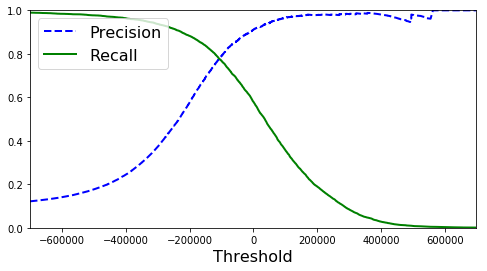

In [29]:
# MODEL - EVALUATE
# FUNCTION TO PLOT PRECISION RECALL

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-700000, 700000])

plt.show()

## ROC - Receiver Operating Characteristic Curve
A great plot for depicting the performance of the binary classifier.

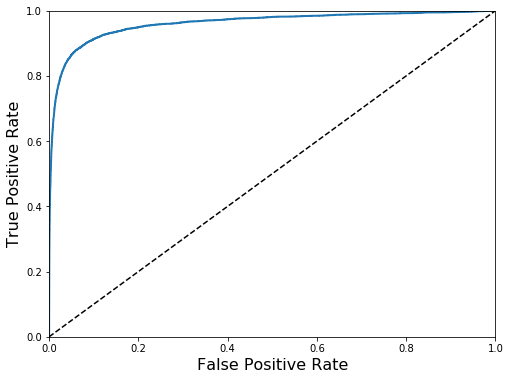

In [30]:
# FROM SKLEARN

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)

plt.show()

In [31]:
# THE AREA UNDER THE CURVE GIVES AN ESTIMATE OF THE PERFORMANCE
# SHOULD BE SIMILAR TO CV SCORES FROM ABOVE

roc_auc_score(y_train_5, y_scores)

0.96074992493648259

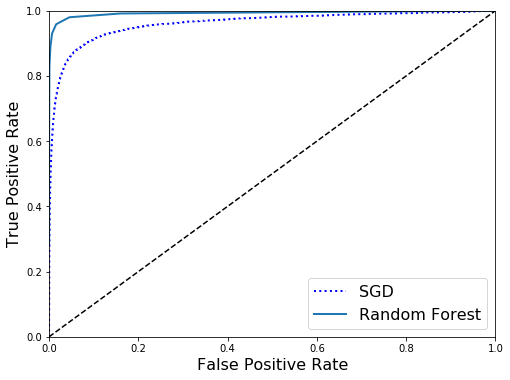

In [32]:
# TRY THE PERFORMANCE WITH ANOTHER CLASSIFIER 
# USE RANDOM FOREST

# CREATE CLASSIFIER
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")


y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

# NOW PLOT THE RF VERSUS THE SGD

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right", fontsize=16)

plt.show()

RF Model dominates the performance of the base SGD.  Checking the AUC should validate what we see visually.

In [34]:
# COMPARE AREA UNDER CURVE

roc_auc_score(y_train_5, y_scores_forest)


0.99256310041033546

## Multiclass

A quick look at a multiclass problem using the entire MNIST set - not just the 5.


In [35]:
# OBTAIN
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-329790.09400678, -386390.33518787, -457221.19389348,
        -163494.82723664, -402146.82411993,  115452.75432867,
        -754954.10527593, -375808.72419686, -748731.63265657,
        -823370.14970414]])

In [36]:
np.argmax(some_digit_scores)


5

In [37]:
sgd_clf.classes_


array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.])

In [38]:
sgd_clf.classes_[5]


5.0

In [39]:
# MODEL - NEW CLASSIFIER
# USING ONE VERSUS ONE TO DETERMINE IDENTIFY
# ACROSS MULTIPLE CLASSES

ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

C:\Users\datab\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


array([ 5.])

In [43]:
# EXPLORE
# HOW MANY ESTIMATORS IN OUR MODEL

len(ovo_clf.estimators_)

45

In [40]:
# MODEL - USING FOREST CLASSIFIER AGAIN

forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])
forest_clf.predict_proba([some_digit])

array([[ 0. ,  0.1,  0. ,  0. ,  0. ,  0.9,  0. ,  0. ,  0. ,  0. ]])

In [41]:
# MODEL - EVALUATE

cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([ 0.8529794 ,  0.84644232,  0.86828024])

In [42]:
# SCRUB - TRANSFORM
# RESULTS WITHOUT TRANSFORMATION WERE NOT GREAT

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([ 0.91276745,  0.90974549,  0.91033655])

In [43]:
# MODEL - EVALUATE

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5743,    2,   22,   11,   15,   37,   39,    8,   42,    4],
       [   1, 6488,   45,   21,    5,   38,    6,    9,  119,   10],
       [  58,   35, 5346,   95,   80,   21,   94,   52,  162,   15],
       [  45,   46,  123, 5341,    2,  237,   36,   56,  149,   96],
       [  20,   29,   37,    6, 5386,   10,   52,   31,   86,  185],
       [  72,   45,   30,  190,   71, 4592,  114,   29,  185,   93],
       [  38,   23,   52,    1,   48,   85, 5614,   10,   47,    0],
       [  22,   21,   68,   27,   56,   12,    5, 5817,   16,  221],
       [  48,  154,   65,  145,   11,  149,   56,   23, 5079,  121],
       [  45,   31,   24,   86,  171,   32,    3,  220,   86, 5251]], dtype=int64)

In [44]:
# FUNCTION FOR CONFUSION MATRIX - VISUAL
def plot_confusion_matrix(matrix):
    """If you prefer color and a colorbar"""
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

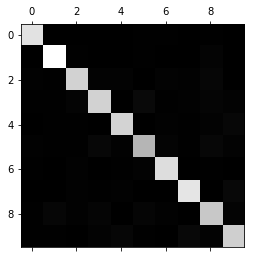

In [45]:
# EXPLORE - SHOW VISUAL OF CONFUSION MATRIX

plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

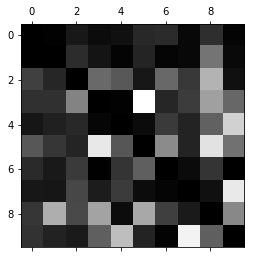

In [46]:
# SHOW CONFUSION MATRIX WITH MORE DETAIL

row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums


np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [47]:
# MODEL
# USE K-NEAREST NEIGHBORS

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [48]:
# MODEL 
# HOW DO WE DO AGAINST 5?

knn_clf.predict([some_digit])

array([[False,  True]], dtype=bool)

In [50]:
%%time 
# TO CHECK TIME FOR MODELING

# MODEL - USING CROSS VAL ON KNN CLASSIFIER

y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

Wall time: 57min 29s


In [52]:
# MODEL - EVALUATE
# F1 IS THE WEIGHTED AVG OF PRECISION & RECALL

f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.9772309611145007